Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Workflow Profiling

This notebook discusses the use of the `monai.utils.WorkflowProfiler` used to gather information about time requirements of various parts of your workflow. This will cover assessing the time spent in transforms, generating batches, training forward and backward passes, etc. This class gathers information using tracing about what functions/methods are called as well as marking explicit constructs to profile, such as callables and context blocks. 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/modules/workflow_profiling.ipynb)

## Setup environment

In [ ]:
!python -c "import monai" || pip install -q monai-weekly

## Setup imports

In [1]:
import matplotlib.pyplot as plt
import monai
import monai.transforms as mt
import numpy as np
import torch
from monai.config import print_config
from monai.data import DataLoader, Dataset, create_test_image_3d
from monai.losses import DiceLoss
from monai.networks.nets import UNet
from monai.utils import ProfileHandler, WorkflowProfiler
from monai.utils.enums import CommonKeys

print_config()

MONAI version: 1.1.0+11.g7de6c336.dirty
Numpy version: 1.22.2
Pytorch version: 1.13.0+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 7de6c33656a99087ca3b89a817b0879cf093febc
MONAI __file__: /workspace/Code/MONAI/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.0.1
Tensorboard version: 2.11.0
gdown version: 4.6.0
TorchVision version: 0.14.0+cu117
tqdm version: 4.64.1
lmdb version: 1.3.0
psutil version: 5.9.2
pandas version: 1.1.5
einops version: 0.6.0
transformers version: 4.21.3
mlflow version: 2.0.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



# Profiling Components

The `WorkflowProfiler` defines a context manager which is used to start and stop its internal results reading thread and configure tracing. Typically all profiling should be done with the context otherwise the results may not be read and so won't appear in the summary. Methods of this class are provided to create separate context blocks used to time how long it takes to enter and exit, wrappers around callables to time how long calls take, and iterables to time how long item generation takes.

Here the test synthetic dataset is created within such a context to demonstrate using sub-blocks to time parts of a workflow and wrapping callables:

In [2]:
dataset = []
num_items = 30
im_shape = (128, 128, 128)

# create the profiler using None to disable tracing for now
with WorkflowProfiler(call_selector=None) as wp:
    # wrap create_test_image_3d in a function which will log how long invocations take
    gen_func = wp.profile_callable("Data generation func")(create_test_image_3d)

    # enclose code in this context which recalls how long execution took
    with wp.profile_ctx("Generation loop"):
        for _ in range(num_items):
            img, seg = gen_func(*im_shape, num_seg_classes=1)

            dataset.append({CommonKeys.IMAGE: img, CommonKeys.LABEL: seg})

print(wp.get_times_summary())

{'Data generation func': (30, 2.743631247, 0.09145437490000001, 0.003281691035703101, 0.088559922, 0.10231691200000001), 'Generation loop': (1, 3.066672092, 3.066672092, 0.0, 3.066672092, 3.066672092)}


The times summary this produced isn't terribly legible in this form so let's use Pandas to make a nice table in Jupyter:

In [3]:
wp.get_times_summary_pd()

,Count,Total Time (s),Avg,Std,Min,Max
Generation loop,1,3.066672,3.066672,0.000000,3.066672,3.066672
Data generation func,30,2.743631,0.091454,0.003282,0.088560,0.102317


This gives time summaries for the two constructs that were profiled. The "Generation loop" context was entered only once while the "Data generation func" (which was `create_test_image_3d` wrapped in another callable) was called multiple times. A context can be entered and exited multiple times, and multiple different context blocks can have the same name thus accumulating results in one place. 

The raw results can be queried with `get_results` which ensures thread and process safety. This should be called outside the enclosing context to ensure that thread finalisation has taken place before results are gathered. 

In [4]:
results = wp.get_results()
print(results)

{'Data generation func': (ProfileResult(name='Data generation func', time=102316912, filename='/home/localek10/miniconda3/envs/monai/lib/python3.9/contextlib.py', lineno=78, pid=2903028, timestamp='2022-08-04 22:33:36.963247'), ProfileResult(name='Data generation func', time=101687130, filename='/home/localek10/miniconda3/envs/monai/lib/python3.9/contextlib.py', lineno=78, pid=2903028, timestamp='2022-08-04 22:33:37.075643'), ProfileResult(name='Data generation func', time=92454908, filename='/home/localek10/miniconda3/envs/monai/lib/python3.9/contextlib.py', lineno=78, pid=2903028, timestamp='2022-08-04 22:33:37.178883'), ProfileResult(name='Data generation func', time=92993072, filename='/home/localek10/miniconda3/envs/monai/lib/python3.9/contextlib.py', lineno=78, pid=2903028, timestamp='2022-08-04 22:33:37.282907'), ProfileResult(name='Data generation func', time=90628110, filename='/home/localek10/miniconda3/envs/monai/lib/python3.9/contextlib.py', lineno=78, pid=2903028, timestam

The result is a dictionary relating construct names to a list of invocations. Each call or execution of a construct produces a `ProfileResult` object to store information about the call, specifically `time` records how many nanoseconds were taken. Stack inspection and tracing is used to, as best as possible, record where the invocation was in code. The PID is also recorded since results can be collected from subprocesses when `DataLoader` objects are used with process workers. 

## Transform Profiling

Profiling how long each transform takes when executing a pipeline is complex owing to difficulting in determining when a transform runs, what times are taken, what transforms call others, etc. The `WorkflowProfiler` class uses tracing to profile all function/method calls matching a given criteria. In the previous example the criteria function was `None` to disable tracing, however the default is a function which selects only the `__call__` methods of `Transforms` instances. This includes top-level transforms and those called by others, but gives a useful idea of time taken relative to one another. Note that tracing is expensive so the times given are not real-world times but are still useful to identify which transform is expensive. 

<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.


(1, 128, 128, 128) torch.float32
(1, 128, 128, 128) torch.float32


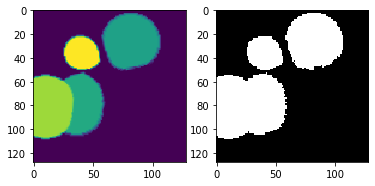

In [5]:
both_keys = (CommonKeys.IMAGE, CommonKeys.LABEL)
rand_prob = 0.5

trans = [
    mt.AddChanneld(both_keys),
    mt.RandSpatialCropd(both_keys, (96, 96, 96), random_size=False),
    mt.ScaleIntensityd(CommonKeys.IMAGE),
    mt.RandAxisFlipd(both_keys, rand_prob),
    mt.RandRotate90d(both_keys, prob=rand_prob, spatial_axes=[0, 1]),
    mt.RandSmoothDeformd(
        keys=both_keys,
        spatial_size=im_shape,
        rand_size=(3, 3, 3),
        pad=2,
        def_range=0.1,
        field_mode=monai.utils.InterpolateMode.TRILINEAR,
        grid_mode=(monai.utils.GridSampleMode.BILINEAR, monai.utils.GridSampleMode.NEAREST),
        align_corners=True,
        prob=1.0,
    ),
    mt.EnsureTyped(both_keys, dtype=(np.float32, np.int32)),
]

train_trans = mt.Compose(trans)

with WorkflowProfiler() as wp:
    test = train_trans(dataset[0])

print(test[CommonKeys.IMAGE].shape, test[CommonKeys.IMAGE].dtype)
print(test[CommonKeys.LABEL].shape, test[CommonKeys.LABEL].dtype)

fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.imshow(test[CommonKeys.IMAGE][0, 48], interpolation="none")
ax1.imshow(test[CommonKeys.LABEL][0, 48], interpolation="none", cmap="gray")

The results is now populated with calls to the `__call__` methods of every transform mentioned above and all those they use. Although tracing has high overhead this still demonstrates that `RandSmoothDeformd` (which uses `RandSmoothDeform`) is the slowest transform defined above by a large margin. Many transforms have very fast total time if by chance they were skipped since their `prob` arguments are less than 1.0. For multiple runs of the same sequence, ie. when generating a whole batch, the results will be more indicative of the time proportion each transform uses. 

In [6]:
wp.get_times_summary_pd()

,Count,Total Time (s),Avg,Std,Min,Max
Compose.__call__,1,0.221865,0.221865,0.000000,0.221865,0.221865
RandSmoothDeformd.__call__,1,0.204633,0.204633,0.000000,0.204633,0.204633
RandSmoothDeform.__call__,2,0.204229,0.102115,0.025176,0.076939,0.127290
RandSpatialCrop.__call__,4,0.006020,0.001505,0.000603,0.000870,0.002146
RandRotate90d.__call__,1,0.004051,0.004051,0.000000,0.004051,0.004051
RandAxisFlipd.__call__,1,0.003834,0.003834,0.000000,0.003834,0.003834
RandSpatialCropd.__call__,1,0.003758,0.003758,0.000000,0.003758,0.003758
Rotate90.__call__,2,0.003532,0.001766,0.000218,0.001548,0.001984
RandAxisFlip.__call__,2,0.003073,0.001537,0.000279,0.001257,0.001816
ScaleIntensityd.__call__,1,0.002638,0.002638,0.000000,0.002638,0.002638


The call selection function can be substituted with any callable which accepts a `frame` object used by `sys.settrace` and `threading.settrace` and returns `True` if the call the frame represents should be traced. The default inspects the frame and returns true if the call is `__call__` and the receiver is a `Transform` instance:

```python
def select_transform_call(frame):
    """Returns True if `frame` is a call to a `Transform` object's `_call__` method."""
    from monai.transforms import Transform  # prevents circular import

    self_obj = frame.f_locals.get("self", None)
    return frame.f_code.co_name == "__call__" and isinstance(self_obj, Transform)
```

You can provide your own criteria functions to replace this one, just don't provide one which traces all calls since this will lead to infinite recursion and be incredibly slow even if that was avoided.

An alternative function to trace only nominated objects may be more useful to narrow the scope of the trace to top-level transforms only: 

In [7]:
class TraceObjectsOnly:
    def __init__(self, objects):
        self.objects = objects

    def __call__(self, frame):
        self_obj = frame.f_locals.get("self", None)
        return frame.f_code.co_name == "__call__" and self_obj in self.objects


# `trans` is the list of transforms defined above, not the Compose object
with WorkflowProfiler(TraceObjectsOnly(trans)) as wp:
    test = train_trans(dataset[0])

wp.get_times_summary_pd()  # much more concise view of what's going on

,Count,Total Time (s),Avg,Std,Min,Max
RandSmoothDeformd.__call__,1,0.195997,0.195997,0.0,0.195997,0.195997
RandAxisFlipd.__call__,1,0.003383,0.003383,0.0,0.003383,0.003383
ScaleIntensityd.__call__,1,0.002526,0.002526,0.0,0.002526,0.002526
RandSpatialCropd.__call__,1,0.002514,0.002514,0.0,0.002514,0.002514
RandRotate90d.__call__,1,0.000955,0.000955,0.0,0.000955,0.000955
EnsureTyped.__call__,1,0.000851,0.000851,0.0,0.000851,0.000851
AddChanneld.__call__,1,0.000499,0.000499,0.0,0.000499,0.000499


## Whole Workflow Profiling

These elements can now be combined to profile all the aspects of the typically Pytorch training workflow:

In [8]:
device = torch.device("cuda:0")
net = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

loss_func = DiceLoss(sigmoid=True)
lr = 1e-3
opt = torch.optim.Adam(net.parameters(), lr)
num_epochs = 3
batch_size = 5


with WorkflowProfiler(TraceObjectsOnly(trans)) as wp:
    # profile how long it takes to create the dataset and loader, this could be long for different dataset types
    with wp.profile_ctx("Create DataLoader"):
        ds = Dataset(dataset, train_trans)
        dl = DataLoader(ds, batch_size=batch_size, num_workers=4)

    # break passes into functions which can be decorated, context blocks in the training loop could be used instead

    @wp.profile_callable()
    def forward_pass(batch):
        img = batch[CommonKeys.IMAGE].to(device)
        seg = batch[CommonKeys.LABEL].to(device)

        return net(img), seg

    @wp.profile_callable()
    def backward_pass(pred, seg):
        loss = loss_func(pred, seg)
        loss.backward()
        return loss

    for epoch in range(1, 1 + num_epochs):
        print("Epoch", epoch)

        # allows measuring how long each epoch takes
        with wp.profile_ctx("Epoch"):
            # measures how long batch generation takes
            for batch in wp.profile_iter("Batch generation", dl):
                opt.zero_grad()
                pred, seg = forward_pass(batch)
                loss = backward_pass(pred, seg)
                opt.step()
                print(loss.item())

wp.get_times_summary_pd()

Epoch 1
0.6061257719993591
0.5812002420425415
0.5409417748451233
0.5432291626930237
0.5123475193977356
0.48115187883377075
Epoch 2
0.48662692308425903
0.5043674111366272
0.45778781175613403
0.5013042092323303
0.4814491271972656
0.4461088180541992
Epoch 3
0.4564221501350403
0.47070246934890747
0.4393620491027832
0.4669444262981415
0.45391151309013367
0.41321325302124023


,Count,Total Time (s),Avg,Std,Min,Max
RandSmoothDeformd.__call__,90,26.779642,0.297552,0.022473,0.237231,0.348664
Epoch,3,12.123880,4.041293,0.070453,3.956572,4.129065
Batch generation,18,5.922669,0.329037,0.577646,0.000066,1.581085
forward_pass,18,1.633583,0.090755,0.180083,0.045593,0.833228
backward_pass,18,1.452966,0.080720,0.003586,0.077889,0.091742
ScaleIntensityd.__call__,90,0.466712,0.005186,0.003002,0.003244,0.016398
RandRotate90d.__call__,90,0.197802,0.002198,0.002198,0.000407,0.008417
RandAxisFlipd.__call__,90,0.194283,0.002159,0.001743,0.000480,0.011748
RandSpatialCropd.__call__,90,0.190021,0.002111,0.001439,0.001370,0.008350
EnsureTyped.__call__,90,0.166541,0.001850,0.000402,0.001582,0.004534


Workflows using Ignite Engine classes can be profiled as well to get very similar results by using `ProfileHandler` to track certain pairs of events. In this example batch generation, iteration, and epoch time are measured using this handler in place of iterator and callable profiling:

In [9]:
from monai.engines import SupervisedTrainer  # noqa
from ignite.engine import Events  # noqa

device = torch.device("cuda:0")
net = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

loss_func = DiceLoss(sigmoid=True)
lr = 1e-3
opt = torch.optim.Adam(net.parameters(), lr)
num_epochs = 3
batch_size = 5

with WorkflowProfiler() as wp:
    with wp.profile_ctx("Create DataLoader"):
        ds = Dataset(dataset, train_trans)
        dl = DataLoader(ds, batch_size=batch_size, num_workers=4)

    trainer = SupervisedTrainer(
        device=device,
        max_epochs=num_epochs,
        train_data_loader=dl,
        network=net,
        optimizer=opt,
        loss_function=loss_func,
    )

    epoch_h = ProfileHandler("Epoch", wp, Events.EPOCH_STARTED, Events.EPOCH_COMPLETED).attach(trainer)
    iter_h = ProfileHandler("Iteration", wp, Events.ITERATION_STARTED, Events.ITERATION_COMPLETED).attach(trainer)
    batch_h = ProfileHandler("Batch gen", wp, Events.GET_BATCH_STARTED, Events.GET_BATCH_COMPLETED).attach(trainer)

    trainer.run()

wp.get_times_summary_pd()

,Count,Total Time (s),Avg,Std,Min,Max
Compose.__call__,90,27.245484,0.302728,0.027476,0.251022,0.357638
RandSmoothDeformd.__call__,90,25.680699,0.285341,0.026100,0.237850,0.341330
RandSmoothDeform.__call__,180,25.644422,0.142469,0.024252,0.101553,0.197427
Epoch,3,11.614823,3.871608,0.111588,3.729614,4.002238
Batch generation,18,6.770129,0.376118,0.689218,0.000098,2.052081
Iteration,18,2.745052,0.152503,0.013247,0.137901,0.176798
ScaleIntensityd.__call__,90,0.464171,0.005157,0.002436,0.003414,0.013247
ScaleIntensity.__call__,90,0.450965,0.005011,0.002414,0.003289,0.013023
RandSpatialCrop.__call__,360,0.407189,0.001131,0.000879,0.000681,0.006411
RandRotate90d.__call__,90,0.269356,0.002993,0.002514,0.000497,0.008461
